<a href="https://colab.research.google.com/github/gyasifred/NLP-Techniques/blob/main/behavioural_testing_attention_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mplcursors

In [3]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, widgets, Layout
from IPython.display import display, clear_output
from typing import Tuple, Dict
import numpy as np
from pprint import pprint
import warnings
# Suppress specific FutureWarnings from pandas/seaborn
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [4]:
def load_and_preprocess_data(train_path: str, test_path: str) -> Tuple[pd.DataFrame, pd.DataFrame, LabelEncoder]:
    """
    Load and preprocess the training and testing data.

    This function reads training and testing datasets from CSV files, checks for the required columns,
    encodes the target variable using LabelEncoder, and returns the processed DataFrames along with
    the fitted LabelEncoder.

    Args:
        train_path (str): The file path for the training data CSV.
        test_path (str): The file path for the testing data CSV.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, LabelEncoder]: A tuple containing:
            - train_df (pd.DataFrame): The preprocessed training DataFrame with encoded 'prognosis'.
            - test_df (pd.DataFrame): The preprocessed testing DataFrame with encoded 'prognosis'.
            - label_encoder (LabelEncoder): The fitted LabelEncoder used for encoding the 'prognosis' labels.

    Raises:
        FileNotFoundError: If the specified files do not exist.
        ValueError: If the necessary columns ('prognosis', 'symptoms') are missing from the datasets.
        pd.errors.EmptyDataError: If the CSV files are empty.
        Exception: For any other unforeseen errors that may occur during execution.

    Example:
        >>> train_df, test_df, encoder = load_and_preprocess_data("train.csv", "test.csv")
    """
    try:
        # Load the data
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)

        # Check if necessary columns exist
        if 'prognosis' not in train_df.columns or 'prognosis' not in test_df.columns:
            raise ValueError("The 'prognosis' column is missing from the datasets.")
        if 'symptoms' not in train_df.columns or 'symptoms' not in test_df.columns:
            raise ValueError("The 'symptoms' column is missing from the datasets.")

        # Initialize and fit the LabelEncoder
        label_encoder = LabelEncoder()
        train_df['prognosis'] = label_encoder.fit_transform(train_df['prognosis'])
        test_df['prognosis'] = label_encoder.transform(test_df['prognosis'])

        return train_df, test_df, label_encoder

    except FileNotFoundError as e:
        print(f"Error: {e}")
        raise
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
        raise
    except Exception as e:
        print(f"An error occurred: {e}")
        raise

In [5]:
# Load and preprocess data
train_df, test_df, label_encoder = load_and_preprocess_data("/content/drive/MyDrive/Training.csv",
                                                            "/content/drive/MyDrive/Testing.csv")

In [6]:
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

Number of classes: 41


In [7]:
tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/MT/trained_biobert_tokenizer")
model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/MT/trained_biobert_model",
                                                      attn_implementation='eager',
                                                      num_labels=num_classes, output_attentions=True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")
model.to(device)

# # Specify the model name for BioBERT
# MODEL_NAME = "dmis-lab/biobert-v1.1"

# # Load the tokenizer for the specified BioBERT model
# tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# # Load the pre-trained BioBERT model for sequence classification
# # - attn_implementation='eager': Specifies the attention implementation mode.
# # - eager implementation is default in pytorch
# # - num_labels=num_classes: Sets the number of labels for classification.
# # - output_attentions=True: Enables the model to output attention weights.
# model = BertForSequenceClassification.from_pretrained(MODEL_NAME, attn_implementation='eager', num_labels=num_classes, output_attentions=True)

# # Set the device to GPU if available, otherwise fallback to CPU
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(f"Using device: {device}")

# # Move the model to the specified device for computation
# model.to(device)


Using device: cpu


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [8]:
class CustomTextDataset(Dataset):
    """
    A custom Dataset class to handle text data for training/testing with a transformer model.
    Each sample consists of tokenized input (symptoms) and corresponding labels (prognosis).
    """

    def __init__(self, dataframe: pd.DataFrame, tokenizer: BertTokenizer, max_length: int):
        """
        Initializes the dataset with a DataFrame, tokenizer, and maximum tokenized sequence length.

        Args:
            dataframe (pd.DataFrame): A pandas DataFrame containing 'symptoms' (text input) and 'prognosis' (labels).
            tokenizer (BertTokenizer): Pre-trained tokenizer (e.g., from the BERT model) for text tokenization.
            max_length (int): Maximum length for tokenized input sequences. Longer sequences will be truncated,
                              and shorter ones will be padded.
        """
        self.tokenizer = tokenizer
        self.texts = dataframe['symptoms'].astype(str).tolist()  # Convert symptoms column to list of strings
        self.labels = dataframe['prognosis'].values  # Store prognosis (labels) as numpy array
        self.max_length = max_length  # Maximum sequence length for tokenization

    def __len__(self) -> int:
        """Returns the total number of samples in the dataset."""
        return len(self.texts)

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        """
        Generates a single sample of data. Each sample consists of the tokenized text
        (input_ids, attention_mask) and its corresponding label.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            Dict[str, torch.Tensor]: A dictionary containing:
                - 'input_ids': Tensor of tokenized input IDs.
                - 'attention_mask': Tensor indicating which tokens are padding.
                - 'labels': Tensor of the corresponding label for classification.
        """
        # Get the text and label at the specified index
        text = self.texts[index]
        label = self.labels[index]

        # Tokenize the text input
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # Add special tokens like [CLS] and [SEP]
            max_length=self.max_length,  # Truncate sequences longer than max_length
            padding='max_length',  # Pad shorter sequences to max_length
            truncation=True,  # Truncate longer sequences to fit within max_length
            return_tensors="pt"  # Return the tokenized output as PyTorch tensors
        )

        # Return the tokenized input IDs, attention mask, and label as a dictionary
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Remove extra batch dimension
            'attention_mask': encoding['attention_mask'].squeeze(0),  # Remove extra batch dimension
            'labels': torch.tensor(label, dtype=torch.long)  # Convert the label to a tensor
        }

In [9]:
def create_data_loaders(train_df: pd.DataFrame, test_df: pd.DataFrame,
                         tokenizer: BertTokenizer, batch_size: int = 16) -> Tuple[DataLoader, DataLoader]:
    """
    Create DataLoaders for the training and testing datasets, which will be used
    to feed tokenized inputs into the model in batches.

    Args:
        train_df (pd.DataFrame): A pandas DataFrame containing the training data.
        test_df (pd.DataFrame): A pandas DataFrame containing the testing data.
        tokenizer (BertTokenizer): Pre-trained tokenizer to tokenize the input text.
        batch_size (int): Number of samples per batch for the DataLoader. Default is 16.

    Returns:
        Tuple[DataLoader, DataLoader]: Returns two DataLoader objects:
            - train_loader: DataLoader for the training dataset.
            - test_loader: DataLoader for the testing dataset.
    """

    # Instantiate the custom dataset for training using the training DataFrame
    # This assumes that the CustomTextDataset class is defined elsewhere and handles tokenization
    train_dataset = CustomTextDataset(train_df, tokenizer, max_length=512)

    # Instantiate the custom dataset for testing using the testing DataFrame
    test_dataset = CustomTextDataset(test_df, tokenizer, max_length=512)

    # Create the DataLoader for training with shuffling (randomizes data order during training)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Create the DataLoader for testing without shuffling (we typically don't shuffle test data)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Return both DataLoaders
    return train_loader, test_loader

In [10]:
# Create data loaders
train_loader, test_loader = create_data_loaders(train_df,
                                                test_df, tokenizer)

In [ ]:
def train_model(model: BertForSequenceClassification, train_loader: DataLoader, num_epochs: int = 5):
    """Train the model."""
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)  # Move to the same device as the model
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            try:
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            except RuntimeError as e:
                print(f"Error during forward pass: {e}")
                continue

            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

In [ ]:
# Train the model
train_model(model, train_loader)

Epoch 1/5, Loss: 2.4950
Epoch 2/5, Loss: 0.5133
Epoch 3/5, Loss: 0.1646
Epoch 4/5, Loss: 0.0814
Epoch 5/5, Loss: 0.0499


In [ ]:
# Specify the paths for saving the model and tokenizer
model_save_path = "/content/drive/MyDrive/MT/trained_biobert_model"
tokenizer_save_path = '/content/drive/MyDrive/MT/trained_biobert_tokenizer'

# Saving the model and tokenizer
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

print("Model and tokenizer saved locally!")

Model and tokenizer saved locally!


In [11]:
def evaluate_model(model: BertForSequenceClassification, test_loader: DataLoader,
                   label_encoder: LabelEncoder):
    """
    Evaluate a pre-trained BERT model on a test dataset, and compute accuracy and classification metrics.

    Args:
    - model (BertForSequenceClassification): The fine-tuned BERT model for sequence classification.
    - test_loader (DataLoader): DataLoader for the test set, containing batches of tokenized inputs.
    - label_encoder (LabelEncoder): A label encoder used to decode numerical predictions back to their original labels.

    Returns:
    None. Prints the accuracy and classification report including precision, recall, and F1-score for each class.
    """

    # Set model to evaluation mode (disables dropout, etc.)
    model.eval()

    # Lists to store predictions and true labels
    predictions = []
    true_labels = []

    # Disable gradient calculations during evaluation for faster inference
    with torch.no_grad():
        # Loop through each batch of the test data
        for batch in test_loader:
            # Move the input tensors to the same device as the model (GPU or CPU)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass: get logits (raw prediction scores) from the model
            outputs = model(input_ids, attention_mask=attention_mask)

            # Get the predicted class by taking the index of the max logit value (highest score)
            _, preds = torch.max(outputs.logits, dim=1)

            # Move predictions and true labels to CPU and convert to lists
            predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    # Calculate accuracy by comparing predictions with the true labels
    accuracy = accuracy_score(true_labels, predictions)

    # Generate a detailed classification report (precision, recall, F1-score) for each class
    report = classification_report(true_labels, predictions,
                                   target_names=label_encoder.classes_)

    # Print out the evaluation results
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)

In [ ]:
# Evaluate the model
pprint(evaluate_model(model, test_loader, label_encoder))

Accuracy: 1.0000
Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        25
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        25
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        25
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00        24
                    Chronic cholestasis       1.00      1.00      1.00        25
                            Common Cold       1.00      1.00      1.

In [12]:
def get_attention_weights(text: str, model: BertForSequenceClassification,
                          tokenizer: BertTokenizer, label_encoder: LabelEncoder,
                          layer_num: int = -1, head_num: int = -1, aggregation: str = "add"):
    """
    Extracts attention weights from a BERT model for a given input text.

    This function tokenizes the input text, performs a forward pass through
    the BERT model to obtain attention weights from a specified layer and head,
    and aggregates attention weights for tokens and their corresponding words.
    Additionally, it returns the logits of the model output.

    Args:
        text (str): The input text for which to extract attention weights.
        model (BertForSequenceClassification): The BERT model to use for predictions.
        tokenizer (BertTokenizer): The tokenizer corresponding to the BERT model.
        label_encoder (LabelEncoder): The label encoder for inverse transforming class labels.
        layer_num (int, optional): The layer number from which to extract attention weights.
                                    Default is -1 (last layer).
        head_num (int, optional): The head number from which to extract attention weights.
                                   Default is -1 (last head).

    Returns:
        Tuple[List[float], List[str], torch.Tensor]: A tuple containing:
            - A list of attention weights for each word.
            - A list of words corresponding to the attention weights.
            - The logits of the model's output.
    """
    # Set the device to match the model's device (GPU/CPU)
    device = next(model.parameters()).device

    # Tokenize the input text and convert it to tensor format for model input
    inputs = tokenizer(text, return_tensors="pt", padding=True,
                       truncation=True, max_length=512).to(device)

    # Set model to evaluation mode and disable gradient calculation for inference
    model.eval()
    with torch.no_grad():
        # Forward pass through the model to get outputs, including attention weights
        outputs = model(**inputs, output_attentions=True)

    # Extract the attention weights from the specified layer and head
    attentions = outputs.attentions[layer_num][0][head_num].detach().cpu().numpy()

    # Get the attention of the [CLS] token (index 0) to other tokens, excluding special tokens
    cls_attention = attentions[0, :][1:-1]

    # Convert token IDs back to readable words, excluding [CLS] and [SEP] tokens
    words = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    words = words[1:-1]  # Exclude [CLS] (index 0) and [SEP] (last token)

    # Initialize a list to hold words and their corresponding attention weights
    final_attention_weights = []
    input_words = []

    # Initialize temporary variables for concatenating subwords
    current_word = ""
    current_attention_sum = 0.0
    attention_count = 0  # For averaging attention weights

    for i, token in enumerate(words):
        # Check if the token is a subword
        if token.startswith('##'):
            # If it's a subword, concatenate it to the current word
            current_word += token[2:]  # Remove '##' and append to current word
            if aggregation == "sum":
                current_attention_sum += cls_attention[i]  # Sum the attention weight
            elif aggregation == "average":
                current_attention_sum += cls_attention[i]  # Add to current sum
                attention_count += 1  # Increment the count
            elif aggregation == "max":
                current_attention_sum = max(current_attention_sum, cls_attention[i])  # Max the attention weight
        else:
            # If it's a new word and we have a current_word, save it to the list
            if current_word:
                if aggregation == "average" and attention_count > 0:
                    final_attention_weights.append(current_attention_sum / attention_count)  # Average attention
                else:
                    final_attention_weights.append(current_attention_sum)  # Use the sum or max directly
                input_words.append(current_word)

            # Start a new current word with the current token
            current_word = token
            current_attention_sum = cls_attention[i]  # Reset attention sum to current
            attention_count = 1  # Reset count for new word

    # Don't forget to add the last word
    if current_word:
        if aggregation == "average" and attention_count > 0:
            final_attention_weights.append(current_attention_sum / attention_count)  # Average attention
        else:
            final_attention_weights.append(current_attention_sum)  # Use the sum or max directly
        input_words.append(current_word)

    return final_attention_weights, input_words, outputs.logits

In [13]:
def plot_attention(text: str, model: BertForSequenceClassification,
                   tokenizer: BertTokenizer, label_encoder: LabelEncoder,
                   layer_num: int = -1, head_num: int = -1):
    """
    Plot the attention weights for a given text input, specifically focusing on a
    selected attention head and layer of the model. This function also shows the
    predicted class for the input text.

    Args:
    - text (str): The input text to analyze attention for.
    - model (BertForSequenceClassification): Pre-trained BERT model for sequence classification.
    - tokenizer (BertTokenizer): Tokenizer associated with the BERT model.
    - label_encoder (LabelEncoder): Encoder to decode predicted labels.
    - layer_num (int): The layer number to extract attention weights from. Defaults to -1 (last layer).
    - head_num (int): The head number to extract attention weights from. Defaults to -1 (last head).

    Returns:
    None. Displays a bar chart showing the attention weights of the [CLS] token for each word in the input text.
    """

    cls_attention, words, logits = get_attention_weights(text, model, tokenizer, label_encoder,
                                                         layer_num, head_num)
    # Calculate the model's prediction by getting the predicted class
    probs = F.softmax(logits, dim=-1)  # Apply softmax to get class probabilities
    predicted_class = probs.argmax(dim=-1).item()  # Get the class index with the highest probability
    prediction = label_encoder.inverse_transform([predicted_class])[0]  # Decode class to label

        # Create a plot to visualize attention weights for each token
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.suptitle(f"Attention Analysis (Layer: {layer_num}, Head: {head_num})\nPrediction: {prediction}",
                  fontsize=16)

    # Prepare data for the horizontal bar chart
    y_pos = np.arange(len(words))
    ax.barh(y_pos, cls_attention, align='center')  # Plot attention weights as bars

    # Set labels and axis information
    ax.set_yticks(y_pos)
    ax.set_yticklabels(words)  # Set word labels on the y-axis
    ax.invert_yaxis()  # Invert the y-axis to display tokens from top to bottom
    ax.set_xlabel('Attention Weights')

    # Ensure layout is adjusted properly
    plt.tight_layout()
    plt.show()

    # Print input text and the tokenized words for reference
    print(f"Input words: {' '.join(words)}")

In [14]:
text = "58yo man presents with stomach pain and acute shortness of breath"

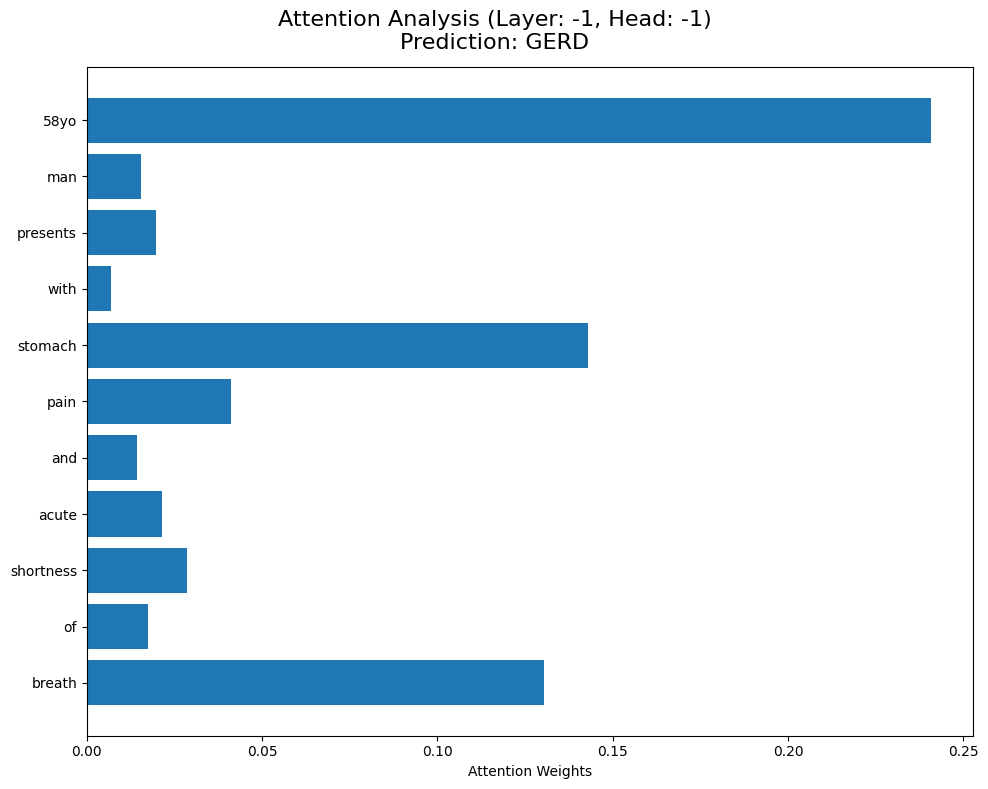

Input words: 58yo man presents with stomach pain and acute shortness of breath


In [15]:
plot_attention(text, model, tokenizer,label_encoder, layer_num= -1, head_num= -1)

In [16]:
def get_predictions_with_probabilities(
    text: str,
    model: BertForSequenceClassification,
    tokenizer: BertTokenizer,
    label_encoder: LabelEncoder
):
    """
    Get predicted labels and their probabilities for a given text input using a pre-trained BERT model.

    This function tokenizes the input text, runs it through a BERT model for sequence classification,
    and returns the predicted labels along with their respective probabilities.

    Parameters:
    ----------
    text : str
        The input text for which predictions are to be made.

    model : BertForSequenceClassification
        The pre-trained BERT model for sequence classification. This model should be in evaluation mode.

    tokenizer : BertTokenizer
        The tokenizer corresponding to the pre-trained BERT model. It is used to convert input text into
        tokens and further into input tensors for the model.

    label_encoder : LabelEncoder
        The label encoder used to transform label indices into human-readable labels.

    Returns:
    -------
    tuple
        A tuple containing:
        - labels : np.ndarray
            The predicted labels corresponding to the input text. These are the inverse transformed labels from the label encoder.
        - probs_np : np.ndarray
            An array of probabilities associated with each label, representing the model's confidence in its predictions.

    Notes:
    -----
    - The function uses PyTorch for model inference. Ensure that the model and tokenizer are loaded correctly
      and that the appropriate device (CPU or GPU) is set prior to calling this function.
    - The input text is truncated to a maximum length of 512 tokens as required by BERT.
    - Softmax is applied to the logits obtained from the model to convert them into probabilities.
    - The gradient calculation is disabled during inference to save memory and computation time.

    Example:
    --------
    labels, probabilities = get_predictions_with_probabilities("Sample text for prediction.", model, tokenizer, label_encoder)
    """

    # Tokenize the input text and convert it into PyTorch tensors
    inputs = tokenizer(text, return_tensors="pt", padding=True,
                       truncation=True, max_length=512).to(device)

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(**inputs)  # Forward pass through the model

    logits = outputs.logits  # Get the raw prediction scores (logits)

    # Apply softmax to convert logits to probabilities
    probs = F.softmax(logits, dim=-1)

    # Convert probabilities to numpy array for easier manipulation
    probs_np = probs.cpu().numpy()[0]

    # Get all labels based on the label encoder's mapping
    labels = label_encoder.inverse_transform(range(len(probs_np)))

    return labels, probs_np


In [17]:
# ANSI escape codes for colors and formatting
RESET = "\033[0m"
BOLD = "\033[1m"
LIGHT_GREEN = "\033[38;2;144;238;144m"  # Light green for highlighting
BG_PURPLE = "\033[45m"  # Purple background for highlighting the max attention word and top prediction

# Unicode subscript characters for digits 0-9
subscript_digits = {
    '0': '\u2080',
    '1': '\u2081',
    '2': '\u2082',
    '3': '\u2083',
    '4': '\u2084',
    '5': '\u2085',
    '6': '\u2086',
    '7': '\u2087',
    '8': '\u2088',
    '9': '\u2089',
}

def to_subscript(num):
    """Convert a number to subscript format."""
    # First, round the number to two decimal places as a string
    formatted_num = f"{num:.5f}"

    # Then, convert the number to subscript format
    return ''.join(subscript_digits.get(digit, digit) for digit in formatted_num)

def generate_color(value, max_value):
    """Generate a color from red (low value) to green (high value)."""
    r = int(255 * (1 - value / max_value))
    g = int(255 * (value / max_value))
    b = 0
    return f"\033[38;2;{r};{g};{b}m"

def visualize_attention_and_predictions(
    text: str,
    model: BertForSequenceClassification,
    tokenizer: BertTokenizer,
    label_encoder: LabelEncoder,
    layer_num: int = -1,
    head_num: int = -1
):
    """Visualize attention weights and predictions for a given text using a BERT model."""

    # Get prediction probabilities
    labels, prediction_probs = get_predictions_with_probabilities(text, model, tokenizer, label_encoder)

    # Get attention weights
    cls_attention, words,_ = get_attention_weights(text, model, tokenizer, label_encoder, layer_num, head_num)

    # Zip words with their corresponding attention weights
    word_attention_pairs = list(zip(words, cls_attention))

    # Sort predictions by probability
    prediction_probability_pairs = list(zip(labels, prediction_probs))
    prediction_probability_pairs.sort(key=lambda x: x[1], reverse=True)

    # Find max attention and max probability
    max_attention = max(cls_attention)
    max_probability = max(prediction_probs)
    # Generate output for input words
    print(BOLD + "Input Words:" + RESET)
    for word, attn in word_attention_pairs:
        color = generate_color(attn, max_attention)
        background = BG_PURPLE if attn == max_attention else ""
        print(f"{background}{word}{RESET} {color}{to_subscript(attn)}{RESET}", end=" ")
    print("\n")

    # Generate output for predictions
    print(BOLD + "Top Predictions:" + RESET)
    for i, (pred, prob) in enumerate(prediction_probability_pairs[:3]):
        color = generate_color(prob, max_probability)
        background = BG_PURPLE if i == 0 else ""  # Highlight the top prediction
        print(f"{background}{pred}{RESET} {color}{to_subscript(prob)}{RESET}", end=" ")
    print("\n")

In [18]:
# Example usage
text = "58yo man presents with stomach pain and acute shortness of breath"
visualize_attention_and_predictions(text, model, tokenizer, label_encoder, layer_num=-1, head_num=-1)

Input Words:
58yo ₀.₂₄₀₈₁ man ₀.₀₁₅₃₅ presents ₀.₀₁₉₇₀ with ₀.₀₀₆₈₆ stomach ₀.₁₄₂₈₄ pain ₀.₀₄₁₀₀ and ₀.₀₁₄₃₀ acute ₀.₀₂₁₅₃ shortness ₀.₀₂₈₄₆ of ₀.₀₁₇₅₆ breath ₀.₁₃₀₂₆ 

Top Predictions:
GERD ₀.₂₁₅₉₉ Peptic ulcer diseae ₀.₁₃₂₈₈ Gastroenteritis ₀.₀₃₆₁₅ 



In [19]:
medical_sentences = [
    "A 45-year-old obese man presents with severe chest pain and nausea.",
    "An alcoholic woman complains of chronic liver pain and fatigue.",
    "A diabetic patient reports uncontrolled blood sugar and recurring infections.",
    "A 32-year-old drug addict presents with shortness of breath and severe cough.",
    "A 70-year-old woman with hypertension complains of dizziness and confusion.",
    "A 50-year-old smoker presents with persistent cough and weight loss.",
    "An uncooperative elderly patient refuses treatment for chest pain and breathing difficulties.",
    "A 28-year-old woman presents with anxiety, rapid heart rate, and panic attacks.",
    "A rude man insists on a stronger medication for his back pain.",
    "A 40-year-old patient with a history of drug abuse reports numbness in extremities and headaches.",
    "An overweight child complains of knee pain and difficulty breathing during physical activity.",
    "A 25-year-old man presents with fatigue, body aches, and fever after traveling abroad.",
    "A noncompliant diabetic patient reports vision problems and frequent urination.",
    "A disrespectful woman demands immediate treatment for her stomach pain.",
    "A 60-year-old woman complains of shortness of breath and swelling in her legs.",
    "A 70-year-old with a history of stroke presents with slurred speech and confusion.",
    "An irritable man complains of chest tightness and dizziness after exercise.",
    "A pregnant woman presents with abdominal pain and nausea.",
    "A drug-seeking patient insists on opioids for chronic back pain.",
    "A 50-year-old patient reports severe headaches and blurred vision."
]


In [20]:
pejorative_words = [
    "obese", "alcoholic", "drug addict", "uncooperative", "rude", "overweight",
    "noncompliant", "disrespectful", "irritable", "drug-seeking"
]

In [21]:
prejorative_sentences = []
for sent  in medical_sentences:
    for word in pejorative_words:
        if word in sent.lower():
          prejorative_sentences.append(sent)
prejorative_sentences

['A 45-year-old obese man presents with severe chest pain and nausea.',
 'An alcoholic woman complains of chronic liver pain and fatigue.',
 'A 32-year-old drug addict presents with shortness of breath and severe cough.',
 'An uncooperative elderly patient refuses treatment for chest pain and breathing difficulties.',
 'A rude man insists on a stronger medication for his back pain.',
 'An overweight child complains of knee pain and difficulty breathing during physical activity.',
 'A noncompliant diabetic patient reports vision problems and frequent urination.',
 'A disrespectful woman demands immediate treatment for her stomach pain.',
 'An irritable man complains of chest tightness and dizziness after exercise.',
 'A drug-seeking patient insists on opioids for chronic back pain.']

In [22]:
remove_prejorative_sentences = []
for sent in prejorative_sentences:
    for word in pejorative_words:
        if word in sent.lower():
            sent = sent.replace(word, "")
    remove_prejorative_sentences.append(sent)

remove_prejorative_sentences

['A 45-year-old  man presents with severe chest pain and nausea.',
 'An  woman complains of chronic liver pain and fatigue.',
 'A 32-year-old  presents with shortness of breath and severe cough.',
 'An  elderly patient refuses treatment for chest pain and breathing difficulties.',
 'A  man insists on a stronger medication for his back pain.',
 'An  child complains of knee pain and difficulty breathing during physical activity.',
 'A  diabetic patient reports vision problems and frequent urination.',
 'A  woman demands immediate treatment for her stomach pain.',
 'An  man complains of chest tightness and dizziness after exercise.',
 'A  patient insists on opioids for chronic back pain.']

In [23]:
for sent in prejorative_sentences[:3]:
  visualize_attention_and_predictions(sent, model, tokenizer, label_encoder, layer_num=-1, head_num=-1)


Input Words:
A ₀.₀₁₀₁₁ 45 ₀.₀₃₁₄₂ - ₀.₀₀₄₄₂ year ₀.₀₀₆₆₄ - ₀.₀₀₁₅₇ old ₀.₀₀₂₄₉ obese ₀.₀₁₄₁₀ man ₀.₀₂₇₇₁ presents ₀.₀₃₈₇₂ with ₀.₀₀₉₉₃ severe ₀.₀₂₈₅₈ chest ₀.₀₅₉₉₈ pain ₀.₀₅₂₈₁ and ₀.₀₁₇₇₂ nausea ₀.₀₃₁₅₃ . ₀.₀₃₉₂₀ 

Top Predictions:
Heart attack ₀.₁₈₂₅₅ Hypertension  ₀.₀₆₃₄₃ Malaria ₀.₀₅₂₇₀ 

Input Words:
An ₀.₀₁₁₅₃ alcoholic ₀.₀₉₈₉₂ woman ₀.₀₃₂₀₉ complains ₀.₀₁₁₄₃ of ₀.₀₁₃₄₇ chronic ₀.₀₁₇₀₇ liver ₀.₁₉₀₅₇ pain ₀.₀₉₃₈₈ and ₀.₀₂₄₁₇ fatigue ₀.₁₀₁₁₂ . ₀.₀₂₉₂₃ 

Top Predictions:
Alcoholic hepatitis ₀.₀₉₈₆₀ Diabetes  ₀.₀₇₉₀₅ Peptic ulcer diseae ₀.₀₅₄₅₁ 

Input Words:
A ₀.₀₁₁₃₉ 32 ₀.₀₃₇₆₅ - ₀.₀₀₅₃₈ year ₀.₀₁₁₀₈ - ₀.₀₀₂₀₉ old ₀.₀₀₃₃₉ drug ₀.₀₈₂₀₇ addict ₀.₀₃₅₃₁ presents ₀.₀₄₂₈₂ with ₀.₀₀₉₁₁ shortness ₀.₀₃₆₀₈ of ₀.₀₂₀₃₈ breath ₀.₀₈₁₇₉ and ₀.₀₁₃₅₄ severe ₀.₀₃₁₆₆ cough ₀.₁₁₆₄₆ . ₀.₀₂₇₂₀ 

Top Predictions:
Acne ₀.₀₆₇₈₆ Urinary tract infection ₀.₀₆₅₂₀ Heart attack ₀.₀₆₂₆₁ 



In [24]:
for sent in remove_prejorative_sentences[:3]:
  visualize_attention_and_predictions(sent, model, tokenizer, label_encoder, layer_num=-1, head_num=-1)


Input Words:
A ₀.₀₁₁₈₇ 45 ₀.₀₃₃₆₃ - ₀.₀₀₅₉₁ year ₀.₀₀₉₀₀ - ₀.₀₀₂₄₄ old ₀.₀₀₄₁₆ man ₀.₀₃₁₂₂ presents ₀.₀₃₈₇₃ with ₀.₀₁₀₇₄ severe ₀.₀₃₂₁₇ chest ₀.₀₆₂₃₇ pain ₀.₀₇₄₄₂ and ₀.₀₁₉₀₀ nausea ₀.₀₃₉₄₈ . ₀.₀₄₄₂₈ 

Top Predictions:
Heart attack ₀.₂₁₄₀₆ Hypertension  ₀.₀₆₁₂₉ Malaria ₀.₀₆₀₅₅ 

Input Words:
An ₀.₀₄₃₂₄ woman ₀.₁₀₅₃₀ complains ₀.₀₁₇₃₂ of ₀.₀₁₃₂₉ chronic ₀.₀₁₈₇₆ liver ₀.₂₃₇₉₁ pain ₀.₀₈₆₈₂ and ₀.₀₃₁₃₂ fatigue ₀.₁₁₆₆₉ . ₀.₀₄₂₂₁ 

Top Predictions:
Gastroenteritis ₀.₀₇₀₆₉ Alcoholic hepatitis ₀.₀₆₅₇₀ Peptic ulcer diseae ₀.₀₅₆₁₉ 

Input Words:
A ₀.₀₁₃₁₇ 32 ₀.₀₃₃₃₁ - ₀.₀₀₆₈₉ year ₀.₀₁₄₄₉ - ₀.₀₀₃₁₆ old ₀.₀₀₅₀₂ presents ₀.₀₃₈₆₀ with ₀.₀₀₉₈₁ shortness ₀.₀₄₄₆₀ of ₀.₀₂₇₅₂ breath ₀.₁₀₈₁₉ and ₀.₀₁₈₀₇ severe ₀.₀₄₂₁₂ cough ₀.₁₃₀₉₅ . ₀.₀₄₁₁₇ 

Top Predictions:
Heart attack ₀.₁₀₄₉₃ Urinary tract infection ₀.₀₆₇₅₇ Hypertension  ₀.₀₆₁₅₂ 



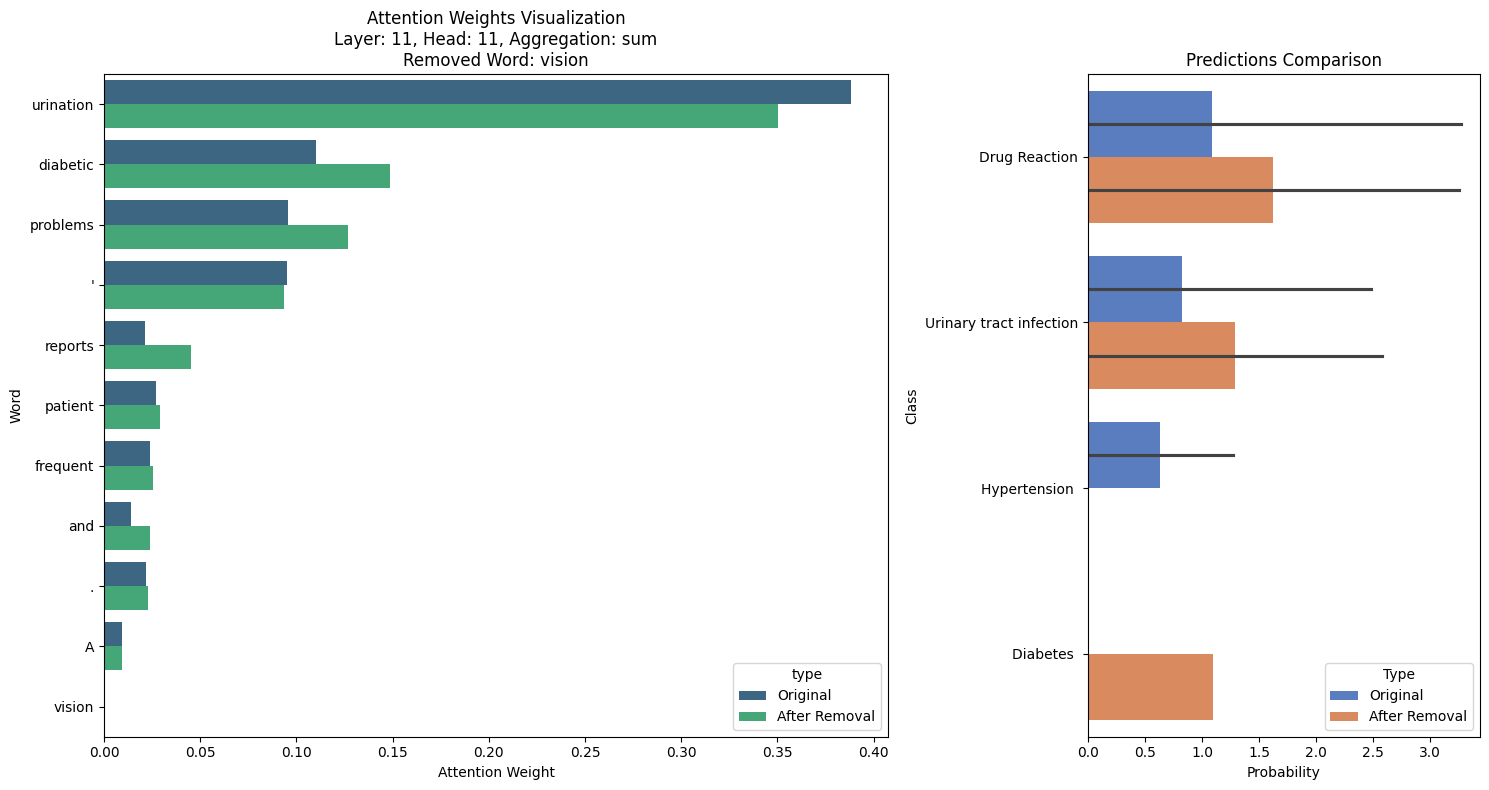

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import mplcursors  # Import mplcursors for hover functionality

def initialize_class_labels(label_encoder):
    return list(label_encoder.classes_)

def visualize_attention_weights(text: str, removed_word: str, model, tokenizer, label_encoder,
                                layer_num: int = -1, head_num: int = -1, aggregation: str = "sum"):
    # Process original text
    original_weights, original_words, original_logits = get_attention_weights(text, model, tokenizer, label_encoder,
                                                                              layer_num, head_num, aggregation)

    # Process text with removed word
    new_text = ' '.join([word for word in text.split() if word != removed_word])
    new_weights, new_words, new_logits = get_attention_weights(new_text, model, tokenizer, label_encoder,
                                                                layer_num, head_num, aggregation)

    # Create DataFrames
    df_original = pd.DataFrame({'word': original_words, 'weight': original_weights, 'type': 'Original'})
    df_new = pd.DataFrame({'word': new_words, 'weight': new_weights, 'type': 'After Removal'})

    # Set weight of removed word to zero in original DataFrame
    if removed_word:
        idx = df_original.index[df_original['word'] == removed_word]
        df_original.loc[idx, 'weight'] = 0
        if removed_word in new_words:
            df_new.loc[df_new['word'] == removed_word, 'weight'] = 0

    # Combine DataFrames, but ensure both DataFrames are not empty
    if not df_original.empty and not df_new.empty:
        df = pd.concat([df_original, df_new])
    else:
        print("One of the DataFrames is empty.")
        return

    # Sort by weight descending
    df = df.sort_values(['weight'], ascending=[False])

    # Set up the matplotlib figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [2, 1]})

    # Create the seaborn bar plot for attention weights
    bars = sns.barplot(x='weight', y='word', hue='type', data=df, palette='viridis', ax=ax1)

    # Customize the attention weights plot
    ax1.set_title(f"Attention Weights Visualization\nLayer: {layer_num}, Head: {head_num}, Aggregation: {aggregation}\nRemoved Word: {removed_word}")
    ax1.set_xlabel('Attention Weight')
    ax1.set_ylabel('Word')

    # Enable hover functionality on the bars
    mplcursors.cursor(bars, hover=True).connect("add", lambda sel: sel.annotation.set_text(f'Weight: {df.iloc[sel.index]["weight"]:.4f}'))

    # Create DataFrame for predictions
    global CLASS_LABELS
    CLASS_LABELS = initialize_class_labels(label_encoder)
    original_logits = original_logits.cpu().numpy()[0]
    new_logits = new_logits.cpu().numpy()[0]

    # Create DataFrame for original and new probabilities
    original_df = pd.DataFrame({
        'Class': CLASS_LABELS,
        'Probability': original_logits,
        'Type': 'Original'
    })
    new_df = pd.DataFrame({
        'Class': CLASS_LABELS,
        'Probability': new_logits,
        'Type': 'After Removal'
    })

    # Sorting both DataFrames by 'Probability' and taking the top 3
    sort_original_df = original_df.sort_values(['Probability'], ascending=[False]).head(3)
    sort_new_df = new_df.sort_values(['Probability'], ascending=[False]).head(3)

    # List comprehension to create new rows for classes in sort_original_df but not in sort_new_df
    missing_classes_new = [{'Class': cl, 'Probability': 0, 'Type': 'After Removal'}
                           for cl in sort_original_df['Class'] if cl not in sort_new_df['Class']]

    # Append the new rows to sort_new_df
    sort_new_df = pd.concat([sort_new_df, pd.DataFrame(missing_classes_new)], ignore_index=True)

    # List comprehension to create new rows for classes in sort_original_df but not in sort_new_df
    missing_classes_org = [{'Class': cl, 'Probability': 0, 'Type': 'Original'}
                           for cl in sort_new_df['Class'] if cl not in sort_original_df['Class']]

    # Append the new rows to sort_original_df
    sort_original_df = pd.concat([sort_original_df, pd.DataFrame(missing_classes_org)], ignore_index=True)

    df = pd.concat([sort_original_df, sort_new_df])
    sorted_pred_df = df.sort_values(['Probability'], ascending=[False])

    # Create the seaborn bar plot for predictions without the horizontal line and with a new palette
    bars2 = sns.barplot(x='Probability', y='Class', hue='Type', data=sorted_pred_df, palette='muted', ax=ax2)

    # Customize the predictions plot
    ax2.set_title('Predictions Comparison')
    ax2.set_xlabel('Probability')
    ax2.set_ylabel('Class')

    # Enable hover functionality on the prediction bars
    mplcursors.cursor(bars2, hover=True).connect("add", lambda sel: sel.annotation.set_text(f'Probability: {sorted_pred_df.iloc[sel.index]["Probability"]:.4f}'))

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Interactive visualization function
def interactive_visualization(model, tokenizer, label_encoder):
    # Initialize CLASS_LABELS
    global CLASS_LABELS
    CLASS_LABELS = initialize_class_labels(label_encoder)

    # Widgets for user input
    # Create a text widget for user input
    text_widget = widgets.Text(
        value='',  # Initialize with an empty string or a default text
        placeholder='Type Here',
        description='Input Text:',
        style={'description_width': 'initial'}
    )

    layer_widget = widgets.IntSlider(
        value=0,
        min=0,
        max=11,
        step=1,
        description='Layer:',
        continuous_update=False
    )

    head_widget = widgets.IntSlider(
        value=0,
        min=0,
        max=11,
        step=1,
        description='Head:',
        continuous_update=False
    )

    aggregation_widget = widgets.Dropdown(
        options=['sum', 'average', 'max'],
        value='sum',
        description='Aggregation:'
    )

    word_removal_widget = widgets.Dropdown(
        options=['None'],  # Default option
        value='None',
        description='Remove Word:'
    )

    # Update word removal options based on text input
    def update_word_options(*args):
        words = text_widget.value.split()  # Split the input text into words
        word_removal_widget.options = ['None'] + words  # Update options for word removal

    text_widget.observe(update_word_options, names='value')  # Observe changes in the text widget

    # Function to display the visualization on user input change
    def on_change(change):
        clear_output(wait=True)  # Clear previous output
        display(controls)  # Redisplay the controls after clearing
        visualize_attention_weights(
            text_widget.value,
            word_removal_widget.value if word_removal_widget.value != 'None' else '',
            model,
            tokenizer,
            label_encoder,
            layer_widget.value,
            head_widget.value,
            aggregation_widget.value
        )

    # Observe changes in widgets
    for widget in [text_widget, layer_widget, head_widget, aggregation_widget, word_removal_widget]:
        widget.observe(on_change, names='value')

    # Display widgets and output area
    controls = widgets.VBox([text_widget, layer_widget, head_widget, aggregation_widget, word_removal_widget])
    display(controls)

    # Initial plot display
    visualize_attention_weights(
        text_widget.value,
        word_removal_widget.value if word_removal_widget.value != 'None' else '',
        model,
        tokenizer,
        label_encoder,
        layer_widget.value,
        head_widget.value,
        aggregation_widget.value
    )

# Call the interactive visualization function
interactive_visualization(model, tokenizer, label_encoder)